## This is an algorithm that create and train a LSTM model that predict the max, min and mean for the future period of time of S&P index

### Loading packages

In [1]:
import numpy as np
import pandas as pd
from textblob import TextBlob as tb
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Concatenate
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
def df_alginer(dfs):
    # get all columns
    index_seq = []
    for df in dfs:
        index_seq += list(df.columns)
    
    # concatenate and align
    tmp = pd.concat(dfs, axis=1, join="inner")
    return tmp
    tmp = tmp.reindex(columns=index_seq)
    
    # retrieve pds back
    for i in range(0, len(dfs)):
        dfs[i] = tmp.iloc[:, sum([len(dfs[j].columns) for j in range(0, i)])
                          :sum([len(dfs[j].columns) for j in range(0, i+1)])]
    return dfs

In [3]:
sent_df = pd.read_csv("reddit_news_sentiment_analysis.csv", index_col=[0], parse_dates=[0]).iloc[3:, 1:].iloc[::-1]
sent_df = sent_df.convert_objects(convert_numeric=True)
sent_df = sent_df.groupby(level=0).mean()

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [4]:
index_df = pd.read_csv("^GSPC.csv", index_col=[0], parse_dates=[0]).iloc[1:, :-1]

In [5]:
df = index_df.join(sent_df, how='inner', rsuffix='_1').iloc[:, [4, 5]]

In [61]:
test_split = int(0.8 * len(df))
valid_split = int(0.95 * len(df))
seq_len = 50
train_seq = np.array([df.iloc[i-seq_len:i, 1] for i in range(seq_len, test_split)])
train_label = np.array([abs(df.iloc[i:i+10, 0].mean() / df.iloc[i-10:i, 0].mean() - 1) > 0.005 for i in range(seq_len, test_split)])

test_seq = np.array([df.iloc[i-seq_len:i, 1] for i in range(test_split, valid_split)])
test_label = np.array([abs(df.iloc[i:i+10, 0].mean() / df.iloc[i-10:i, 0].mean() - 1) > 0.005 for i in range(test_split, valid_split)])

valid_seq = np.array([df.iloc[i-seq_len:i, 1] for i in range(valid_split, len(df))])
valid_label = np.array([abs(df.iloc[i:i+10, 0].mean() / df.iloc[i-10:i, 0].mean() - 1) > 0.005 for i in range(valid_split, len(df))])



In [66]:
# flow for prev_label_input
seq_input = Input(shape=(seq_len,), name="sequence_input")
x = Dense(units=64, activation="relu", name="output_feature")(seq_input)
x = Dropout(0.5)(x)
x = Dense(units=64, activation="relu", name="output_feature")(seq_input)
x = Dropout(0.5)(x)
output = Dense(units=1, activation="sigmoid", name="output")(x)

# compile model
Senti = Model(inputs=[seq_input], outputs=[output])
Senti.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.005), metrics=["binary_crossentropy"])
# Senti.compile(loss="mse", optimizer=Adam(lr=0.005), metrics=["mse"])

# display model
Senti.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  (None, 50)                0         
_________________________________________________________________
output_feature (Dense)       (None, 64)                3264      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________


In [70]:
Senti.fit(x=train_seq, y=[train_label], validation_data=[test_seq, test_label], epochs=1000, batch_size=256, shuffle=True, verbose=1)

Train on 1575 samples, validate on 305 samples
Epoch 1/1000
1575/1575 [==============================] - 0s 11us/step - loss: 0.1085 - binary_crossentropy: 0.1085 - val_loss: 1.2814 - val_binary_crossentropy: 1.2814
Epoch 2/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.1085 - binary_crossentropy: 0.1085 - val_loss: 1.2893 - val_binary_crossentropy: 1.2893
Epoch 3/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.1054 - binary_crossentropy: 0.1054 - val_loss: 1.2655 - val_binary_crossentropy: 1.2655
Epoch 4/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.1037 - binary_crossentropy: 0.1037 - val_loss: 1.2386 - val_binary_crossentropy: 1.2386
Epoch 5/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.1170 - binary_crossentropy: 0.1170 - val_loss: 1.2052 - val_binary_crossentropy: 1.2052
Epoch 6/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.1071 - binary_crossentropy: 0.1

1575/1575 [==============================] - 0s 10us/step - loss: 0.1023 - binary_crossentropy: 0.1023 - val_loss: 1.3544 - val_binary_crossentropy: 1.3544
Epoch 98/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.1027 - binary_crossentropy: 0.1027 - val_loss: 1.3755 - val_binary_crossentropy: 1.3755
Epoch 99/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0954 - binary_crossentropy: 0.0954 - val_loss: 1.3725 - val_binary_crossentropy: 1.3725
Epoch 100/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0874 - binary_crossentropy: 0.0874 - val_loss: 1.3699 - val_binary_crossentropy: 1.3699
Epoch 101/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0999 - binary_crossentropy: 0.0999 - val_loss: 1.3674 - val_binary_crossentropy: 1.3674
Epoch 102/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0925 - binary_crossentropy: 0.0925 - val_loss: 1.3734 - val_binary_crossentropy: 1

1575/1575 [==============================] - 0s 10us/step - loss: 0.0887 - binary_crossentropy: 0.0887 - val_loss: 1.4796 - val_binary_crossentropy: 1.4796
Epoch 194/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0871 - binary_crossentropy: 0.0871 - val_loss: 1.4289 - val_binary_crossentropy: 1.4289
Epoch 195/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0882 - binary_crossentropy: 0.0882 - val_loss: 1.4200 - val_binary_crossentropy: 1.4200
Epoch 196/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0905 - binary_crossentropy: 0.0905 - val_loss: 1.4385 - val_binary_crossentropy: 1.4385
Epoch 197/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0861 - binary_crossentropy: 0.0861 - val_loss: 1.4700 - val_binary_crossentropy: 1.4700
Epoch 198/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0770 - binary_crossentropy: 0.0770 - val_loss: 1.4829 - val_binary_crossentrop

1575/1575 [==============================] - 0s 10us/step - loss: 0.0844 - binary_crossentropy: 0.0844 - val_loss: 1.5665 - val_binary_crossentropy: 1.5665
Epoch 290/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0747 - binary_crossentropy: 0.0747 - val_loss: 1.5486 - val_binary_crossentropy: 1.5486
Epoch 291/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0767 - binary_crossentropy: 0.0767 - val_loss: 1.5387 - val_binary_crossentropy: 1.5387
Epoch 292/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0780 - binary_crossentropy: 0.0780 - val_loss: 1.5579 - val_binary_crossentropy: 1.5579
Epoch 293/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0694 - binary_crossentropy: 0.0694 - val_loss: 1.5957 - val_binary_crossentropy: 1.5957
Epoch 294/1000
1575/1575 [==============================] - 0s 14us/step - loss: 0.0762 - binary_crossentropy: 0.0762 - val_loss: 1.6190 - val_binary_crossentropy

1575/1575 [==============================] - 0s 10us/step - loss: 0.0717 - binary_crossentropy: 0.0717 - val_loss: 1.7388 - val_binary_crossentropy: 1.7388
Epoch 386/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0683 - binary_crossentropy: 0.0683 - val_loss: 1.7046 - val_binary_crossentropy: 1.7046
Epoch 387/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0662 - binary_crossentropy: 0.0662 - val_loss: 1.6834 - val_binary_crossentropy: 1.6834
Epoch 388/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0816 - binary_crossentropy: 0.0816 - val_loss: 1.6973 - val_binary_crossentropy: 1.6973
Epoch 389/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0783 - binary_crossentropy: 0.0783 - val_loss: 1.6966 - val_binary_crossentropy: 1.6966
Epoch 390/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0789 - binary_crossentropy: 0.0789 - val_loss: 1.6820 - val_binary_crossentropy

1575/1575 [==============================] - 0s 10us/step - loss: 0.0692 - binary_crossentropy: 0.0692 - val_loss: 1.7923 - val_binary_crossentropy: 1.7923
Epoch 482/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0570 - binary_crossentropy: 0.0570 - val_loss: 1.8030 - val_binary_crossentropy: 1.8030
Epoch 483/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0720 - binary_crossentropy: 0.0720 - val_loss: 1.8082 - val_binary_crossentropy: 1.8082
Epoch 484/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0625 - binary_crossentropy: 0.0625 - val_loss: 1.7830 - val_binary_crossentropy: 1.7830
Epoch 485/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0655 - binary_crossentropy: 0.0655 - val_loss: 1.8227 - val_binary_crossentropy: 1.8227
Epoch 486/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0639 - binary_crossentropy: 0.0639 - val_loss: 1.8480 - val_binary_crossentropy:

1575/1575 [==============================] - 0s 9us/step - loss: 0.0617 - binary_crossentropy: 0.0617 - val_loss: 2.0800 - val_binary_crossentropy: 2.0800
Epoch 578/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0526 - binary_crossentropy: 0.0526 - val_loss: 2.1176 - val_binary_crossentropy: 2.1176
Epoch 579/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0609 - binary_crossentropy: 0.0609 - val_loss: 2.1166 - val_binary_crossentropy: 2.1166
Epoch 580/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0622 - binary_crossentropy: 0.0622 - val_loss: 2.0867 - val_binary_crossentropy: 2.0867
Epoch 581/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0730 - binary_crossentropy: 0.0730 - val_loss: 2.0498 - val_binary_crossentropy: 2.0498
Epoch 582/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0748 - binary_crossentropy: 0.0748 - val_loss: 2.0280 - val_binary_crossentropy: 2

1575/1575 [==============================] - 0s 9us/step - loss: 0.0535 - binary_crossentropy: 0.0535 - val_loss: 2.2470 - val_binary_crossentropy: 2.2470
Epoch 674/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0576 - binary_crossentropy: 0.0576 - val_loss: 2.2148 - val_binary_crossentropy: 2.2148
Epoch 675/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0571 - binary_crossentropy: 0.0571 - val_loss: 2.1754 - val_binary_crossentropy: 2.1754
Epoch 676/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0581 - binary_crossentropy: 0.0581 - val_loss: 2.2150 - val_binary_crossentropy: 2.2150
Epoch 677/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0545 - binary_crossentropy: 0.0545 - val_loss: 2.2505 - val_binary_crossentropy: 2.2505
Epoch 678/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0551 - binary_crossentropy: 0.0551 - val_loss: 2.2217 - val_binary_crossentropy: 2.

1575/1575 [==============================] - 0s 10us/step - loss: 0.0520 - binary_crossentropy: 0.0520 - val_loss: 2.3712 - val_binary_crossentropy: 2.3712
Epoch 770/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0474 - binary_crossentropy: 0.0474 - val_loss: 2.3855 - val_binary_crossentropy: 2.3855
Epoch 771/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0454 - binary_crossentropy: 0.0454 - val_loss: 2.4365 - val_binary_crossentropy: 2.4365
Epoch 772/1000
1575/1575 [==============================] - 0s 15us/step - loss: 0.0516 - binary_crossentropy: 0.0516 - val_loss: 2.4284 - val_binary_crossentropy: 2.4284
Epoch 773/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0458 - binary_crossentropy: 0.0458 - val_loss: 2.4328 - val_binary_crossentropy: 2.4328
Epoch 774/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0430 - binary_crossentropy: 0.0430 - val_loss: 2.4462 - val_binary_crossentrop

1575/1575 [==============================] - 0s 9us/step - loss: 0.0523 - binary_crossentropy: 0.0523 - val_loss: 2.5254 - val_binary_crossentropy: 2.5254
Epoch 866/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0470 - binary_crossentropy: 0.0470 - val_loss: 2.5987 - val_binary_crossentropy: 2.5987
Epoch 867/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0476 - binary_crossentropy: 0.0476 - val_loss: 2.6518 - val_binary_crossentropy: 2.6518
Epoch 868/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0463 - binary_crossentropy: 0.0463 - val_loss: 2.6299 - val_binary_crossentropy: 2.6299
Epoch 869/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0482 - binary_crossentropy: 0.0482 - val_loss: 2.5874 - val_binary_crossentropy: 2.5874
Epoch 870/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0495 - binary_crossentropy: 0.0495 - val_loss: 2.5702 - val_binary_crossentropy: 2

1575/1575 [==============================] - 0s 10us/step - loss: 0.0493 - binary_crossentropy: 0.0493 - val_loss: 2.7707 - val_binary_crossentropy: 2.7707
Epoch 962/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0473 - binary_crossentropy: 0.0473 - val_loss: 2.7608 - val_binary_crossentropy: 2.7608
Epoch 963/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0352 - binary_crossentropy: 0.0352 - val_loss: 2.7684 - val_binary_crossentropy: 2.7684
Epoch 964/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0432 - binary_crossentropy: 0.0432 - val_loss: 2.7806 - val_binary_crossentropy: 2.7806
Epoch 965/1000
1575/1575 [==============================] - 0s 9us/step - loss: 0.0444 - binary_crossentropy: 0.0444 - val_loss: 2.7776 - val_binary_crossentropy: 2.7776
Epoch 966/1000
1575/1575 [==============================] - 0s 10us/step - loss: 0.0468 - binary_crossentropy: 0.0468 - val_loss: 2.7731 - val_binary_crossentropy:

In [68]:
def compare_output(predicted, correct, title, length=-1):
    if length < 0:
        x = np.arange(0, correct.shape[0] + length)
    else:
        x = np.arange(0, length)
    plt.figure(figsize=(22, 2))
    plt.title(title)
    sample_label, = plt.plot(x, correct[:length], label="sample")
    predict_label, = plt.plot(x, predicted[:length], label="predict")
    plt.legend([sample_label, predict_label], ["sample", "predict"])
    plt.plot()

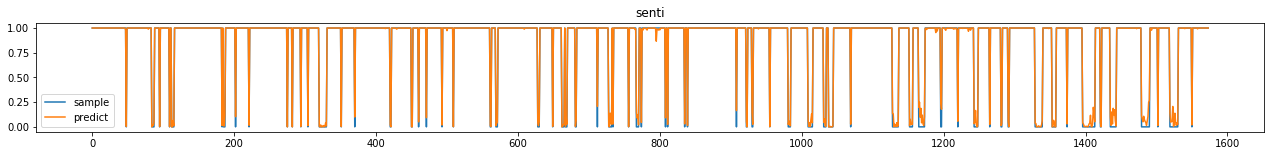

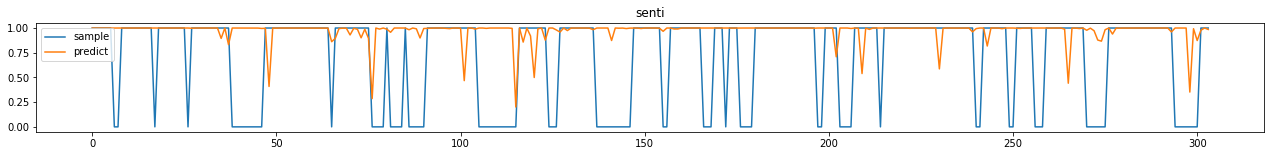

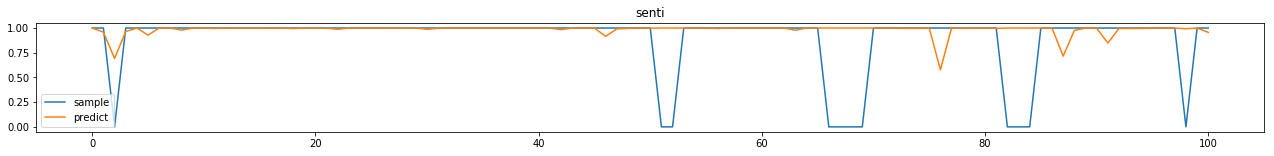

In [71]:
length = -1

predicted = Senti.predict_on_batch(train_seq)
correct = train_label
compare_output(predicted, correct, "senti", length)

predicted = Senti.predict_on_batch(test_seq)
correct = test_label
compare_output(predicted, correct, "senti", length)

predicted = Senti.predict_on_batch(valid_seq)
correct = valid_label
compare_output(predicted, correct, "senti", length)